## Let's train our first PFN to do ridge regression

PFNs are all about fitting priors, thus we need a prior for this.

We will now describe the prior of ridge regression and we will later on prove this in math *and* by example, we will see that the PFN does in fact approximate ridge regression.

### The prior

Our prior has two parts. i) What the mapping from x to y looks like, that is
$$
y \sim Normal(x^Tw, a^2I).
$$
While $x$ is our input, we have two more undefined symbols. $a$ is the standard deviation of our outputs and is fixed upfront to some value, e.g. $0.1$. $w$ on the other hand controls the form of our function, in one d this could e.g. define whether we go up or down with increasing $x$.

As $w$ is so crucial, we define a prior over it, too. That is we say $w \sim Normal(0, b^2I)$ for some other fixed standard deviation $b$. BTW in Bayesian terms a variable like $w$ that controls what our distribution looks like is generally called latent.

The above is the whole prior of ridge regression. We define a distribution over $w$ and then given that $w$ we define a distribution over mappings from $x$ to $y$.


### Generating prior samples for PFN training

All we want to do is train a neural network on datasets sampled from a prior. To do this, we need to define one more thing, that is: we need to define a distribution over $x$ that we consider. For simplicity let us just consider the uniform distribution between 0 and 1.


### Let's generate some samples in 1D

In [1]:
import torch

num_datasets = 10
num_points_in_each_dataset = 100

# Let's fix our constants
a = 0.1
b = 1.0

# Now we go through the above up from the buttom, first we define our samples of w
ws = torch.distributions.Normal(torch.tensor([0.0]), b).sample((num_datasets,)) # a tensor of shape (num_datasets, 1)

# For each constant we generate `num_points_in_each_dataset` many x's and y's
xs = torch.rand(num_datasets, num_points_in_each_dataset, 1)
ys = torch.distributions.Normal(torch.einsum('nmf, nf -> nm', xs, ws), a).sample()

print(xs.shape, ws.shape, ys.shape)

torch.Size([10, 100, 1]) torch.Size([10, 1]) torch.Size([10, 100])


### We can plot our sample datasets
If you change the constants above, you have a lot of impact on this plot.

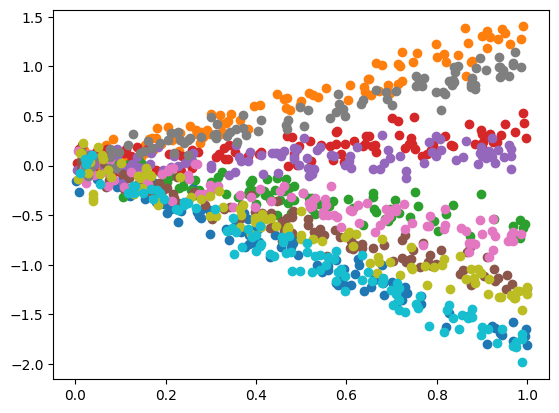

In [4]:
import matplotlib.pyplot as plt

for dataset_index in range(num_datasets):
    plt.scatter(xs[dataset_index,:,0].numpy(), ys[dataset_index].numpy())

### Damn all curves go through the identity...
We can fix that by simply appending a $1$ to each $x$. Let's also generally allow different numbers of features.

In [5]:
def sample_from_prior(num_datasets = 10, num_features=1, num_points_in_each_dataset = 100,
                      hyperparameters={'a': 0.1, 'b': 1.0}):
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((num_datasets,)) # a tensor of shape (num_datasets, 1)

    xs = torch.rand(num_datasets, num_points_in_each_dataset, num_features)
    ys = torch.distributions.Normal(
        torch.einsum('nmf, nf -> nm',
                     torch.cat([xs,torch.ones(num_datasets, num_points_in_each_dataset,1)],2),
                     ws
                    ),
        hyperparameters['a']
    ).sample()
    return xs, ys

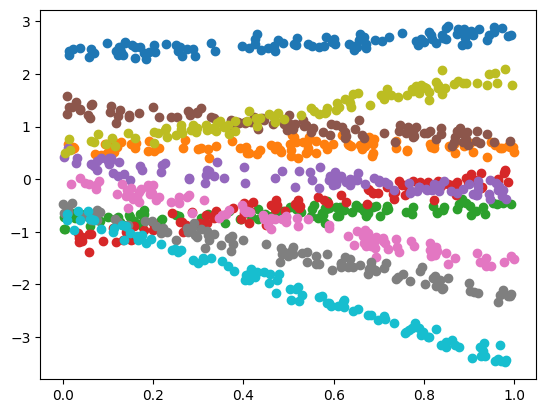

In [6]:
xs, ys = sample_from_prior()
for dataset_index in range(num_datasets):
    plt.scatter(xs[dataset_index,:,0].numpy(), ys[dataset_index].numpy())

### Ok cool. What now? Let's make something for the PFN to train on..

What a PFN does is, given a training set of $(x,y)$ pairs, it learns a predictor internally and predicts the $y$ for another set of $x$ inputs. It also trains like this. During training we automatically split datasets into train and test before feeding them to the PFN.

So, all we need to do is refine our `sample_from_prior` to return datasets s.t. it has the format our training function expects.

We generally call these functions `get_batch` functions, as they are called before each training step to get the training batches, and they look something like this:

In [11]:
from pfns4bo.priors import Batch

# in our convention we name the `num_datasets` -> `batch_size`, and the `num_points_in_each_dataset` -> `seq_len`
# another convetion is to not have the batch size first, but instead the seq len.

def get_batch_for_ridge_regression(batch_size=2,seq_len=100,num_features=1, 
                                   hyperparameters=None, **kwargs):
    if hyperparameters is None:
        hyperparameters = {'a': 0.1, 'b': 1.0}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))

    xs = torch.rand(batch_size, seq_len, num_features)
    ys = torch.distributions.Normal(
        torch.einsum('nmf, nf -> nm',
                     torch.cat([xs,torch.ones(batch_size, seq_len,1)],2),
                     ws
                    ),
        hyperparameters['a']
    ).sample()
    
    # get_batch functions return two different ys, let's come back to this later, though.
    return Batch(x=xs.transpose(0,1), y=ys.transpose(0,1), target_y=ys.transpose(0,1)) # (seq_len, batch_size, num_features), ...


## Train Train Train!!!

### Let's train a mini PFN for 1D datasets with up to 20 elements 🚀

This should take around 1 minute, at least on my machine it does.

#### What happens during training?
During training we sample datasets from our `get_batch` method, we then split them into left and right of the so called `single_eval_pos` (which in turn is sampled uniformly at random). If something is left it is training, on the right it is test. Now our PFN is training to predict the $y$ of the test set, given $x$ and $y$ for the training set, as well as $x$ for the test set.

Our training uses standard Adam and a cross-entropy loss. We use a transformer as PFN, where each example in the training or test set is encoded as a token (sometimes also called time step). More info on the architecture can be found in our paper.

In [9]:
from torch import nn
from pfns4bo.train import train
from pfns4bo.priors.utils import get_batch_to_dataloader
from pfns4bo import encoders
from pfns4bo import utils
from pfns4bo import bar_distribution

# Let's fix some global settings

hps = None
num_features = 1
max_dataset_size = 20

def train_a_pfn(get_batch_function, epochs=20, max_dataset_size=max_dataset_size, num_features=num_features,
                hps=hps,
               ):
    
    # define a bar distribution (riemann distribution) criterion with 1000 bars
    ys = get_batch_function(100000,20,num_features, hyperparameters=hps).target_y
    # we define our bar distribution adaptively with respect to the above sample of target ys from our prior
    criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=1000, ys=ys))

    # now train
    train_result = train(# the prior is the key. It defines what we train on.
                         get_batch_function, criterion=criterion,
                         # define the transformer size
                         emsize=128, nhead=4, nhid=256, nlayers=4, 
                         # how to encode the x and y inputs to the transformer
                         encoder_generator=encoders.get_normalized_uniform_encoder(encoders.Linear),
                         y_encoder_generator=encoders.Linear, 
                         # these are given to the prior, which needs to know how many features we have etc
                         extra_prior_kwargs_dict=\
                            {'num_features': num_features, 'fuse_x_y': False, 'hyperparameters': hps},
                         # change the number of epochs to put more compute into a training
                         # an epoch length is defined by `steps_per_epoch`
                         # the below means we do 10 epochs, with 100 batches per epoch and 4 datasets per batch
                         # that means we look at 10*1000*4 = 4000 datasets. Considerably less than in the demo.
                         epochs=epochs, warmup_epochs=epochs//4, steps_per_epoch=100,batch_size=8,
                         # the lr is what you want to tune! usually something in [.00005,.0001,.0003,.001] works best
                         # the lr interacts heavily with `batch_size` (smaller `batch_size` -> smaller best `lr`)
                         lr=.001,
                         # seq_len defines the size of your datasets (including the test set)
                         seq_len=max_dataset_size,
                         # single_eval_pos_gen defines where to cut off between train and test set
                         # a function that (randomly) returns lengths of the training set
                         # the below definition, will just choose the size uniformly at random up to `max_dataset_size`
                         single_eval_pos_gen=utils.get_uniform_single_eval_pos_sampler(max_dataset_size))
    return train_result

c:\Users\82109\anaconda3\envs\my_pfns4bo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
train_result = train_a_pfn(get_batch_for_ridge_regression)

Using 2000000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 8, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x000001F34F299040>, 'seq_len_maximum': 20, 'device': 'cpu:0', 'num_features': 1, 'fuse_x_y': False, 'hyperparameters': None}, 'num_features': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 1000)  and nout 1000
Using a Transformer with 0.82 M parameters


c:\Users\82109\dsl_lab\PFNs4BO_teajoo\pfns4bo\bar_distribution.py:33: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  target_sample = torch.searchsorted(self.borders, y) - 1


-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  4.73s | mean loss  1.60 | pos losses  1.45, 1.73, 1.54, 1.79, 1.67, 1.59, 1.60, 1.58, 1.51, 1.46, 1.68, 2.18, 1.40, 1.70, 1.66, 1.53, 1.53, 1.40, 1.70, 1.69, lr 0.0 data time  0.00 step time  0.04 forward time  0.01 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  4.43s | mean loss  1.51 | pos losses  1.56, 1.44, 1.68, 1.40, 1.43, 1.32, 1.46, 1.73, 1.44, 1.26, 1.54, 1.58, 1.53, 1.72, 1.34, 1.49, 1.57, 1.66, 1.65, 1.45, lr 0.0002 data time  0.00 step time  0.05 forward time  0.02 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
-----------------------

In [13]:
# Our trained model can be taken from the results as
trained_model = train_result[2]
trained_model

TransformerModel(
  (transformer_encoder): TransformerEncoderDiffInit(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (encoder): Sequential(
    (0): Normalize()
    (1): Linear(in_features=1, out_features=128, bias=True)
  )
  (y_encoder): Linear(in_features=1, out_features=128, bias=True)
  (pos_encoder): NoPositionalEncoding()
  (decoder_dict): ModuleDict(
    (standa

### Analysis of the performance of our trained PFN

In [28]:
# let's sample some datasets to look at
batch = get_batch_for_ridge_regression(seq_len=100, hyperparameters=hps, batch_size=10)
print(batch.x.shape, batch.y.shape, batch.target_y.shape)

torch.Size([100, 10, 1]) torch.Size([100, 10]) torch.Size([100, 10])


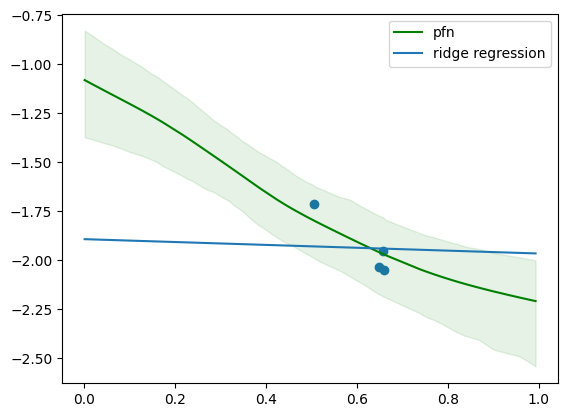

In [29]:
# our model wants the seq dimension first, remember that!

batch_index = 0 # change this to see other examples
num_training_points = 4


train_x = batch.x[:num_training_points, batch_index]
train_y = batch.y[:num_training_points, batch_index]
test_x = batch.x[:, batch_index]


with torch.no_grad():
    # we add our batch dimension, as our transformer always expects that
    logits = trained_model(train_x[:,None], train_y[:,None], test_x[:,None])

# the model has the criterion still attached (it is the same though, as our criterion above)
# the criterion has a lot of handy function to use these logits
pred_means = trained_model.criterion.mean(logits)
pred_confs = trained_model.criterion.quantile(logits)


plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[...,0 , 0][order_test_x], pred_confs[...,0 ,1][order_test_x], alpha=.1, color='green')

import sklearn.linear_model

ridge_model = sklearn.linear_model.Ridge(alpha=(2/3)**2) # a/b
ridge_model.fit(train_x,train_y)
plt.plot(test_x[order_test_x].squeeze(), ridge_model.predict(test_x[order_test_x]), label='ridge regression')
plt.legend()
plt.plot();

### They seem to align kinda well..

.. at least for a PFN trained for 1 minute. If you are now interested in the more theoretical analysis why this prior yields ridge regression, please see https://statisticaloddsandends.wordpress.com/2018/12/29/bayesian-interpretation-of-ridge-regression/.

What we can also see is that our PFN provides us with confidence bounds, unlike ridge regression. This is actually the case out of the box. We use a discretized distribution (the riemann distribution). It can be described as
a piece-wise constant distribution. We just need to find out what good pieces are for our prior.
You can view the discretization in `trained_model.criterion.borders`. We fit them on a lot of samples from our prior.
If you are interested in the way we do regression, see read about the Riemann distribution in our paper https://arxiv.org/abs/2112.10510 or see the code in `bar_distribution.py`.

## Let's do some special stuff!!

So far we only reproduced an algorithm that already exists.
Let's try two more things. 

### i) Sine Ridge Regression


What should **sine ridge regression** be!? It is the same as ridge regression, just that 
we replace our curves with sines.

We can adapt the `get_batch` function from above to get there.

In [19]:
def get_batch_for_sine_ridge_regression(batch_size=10,seq_len=100,num_features=1, 
                                   hyperparameters=None, **kwargs):
    if hyperparameters is None:
        hyperparameters = {'a': 0.01, 'b': 1.0, 's': .3}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))

    xs = torch.rand(batch_size, seq_len, num_features)
    ys = torch.distributions.Normal(
        torch.einsum('nmf, nf -> nm',
                     torch.cat([xs,torch.ones(batch_size, seq_len,1)],2),
                     ws
                    ),
        hyperparameters['a']
    ).sample()
    
    ## the new part
        
    ys += torch.sin(xs[...,0]*20) * hyperparameters['s']
    
    ## end new part
    
    # get_batch functions return two different ys, let's come back to this later, though.
    return Batch(x=xs.transpose(0,1), y=ys.transpose(0,1), target_y=ys.transpose(0,1))



Let's sample from this prior...

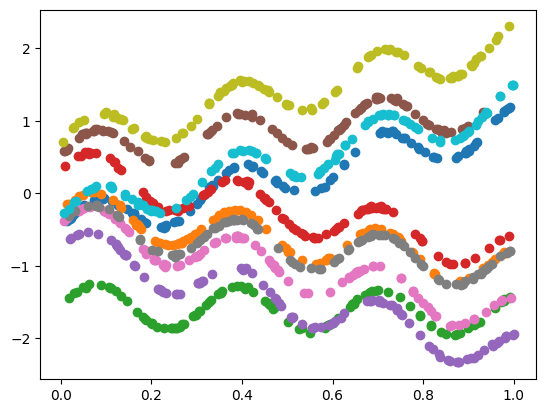

In [20]:
batch = get_batch_for_sine_ridge_regression()
for dataset_index in range(batch.x.shape[1]):
    plt.scatter(batch.x[:,dataset_index,0].numpy(), batch.y[:,dataset_index].numpy())

#### Funky curves, let's train a PFN!!!

In [21]:
train_results_sine = train_a_pfn(get_batch_for_sine_ridge_regression)
trained_model_sine = train_results_sine[2]

Using 2000000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 8, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7fa47da55b40>, 'seq_len_maximum': 20, 'device': 'cpu:0', 'num_features': 1, 'fuse_x_y': False, 'hyperparameters': None}, 'num_features': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 1000)  and nout 1000
Using a Transformer with 0.82 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.74s | mean loss  1.64 | pos losses  1.59, 1.83, 1.63, 1.57, 1.56, 1.48, 1.60, 1.58, 1.65, 1.48, 1.71, 1.73, 1.63, 1.69, 1.69, 1.76, 1.69, 1.52, 1.43, 1.69, lr 0.0 data time  0.00 step time  0.02 forward time  0.01 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------

-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  2.51s | mean loss -0.61 | pos losses  1.48, 0.69,-0.05,-0.43,-0.63,-0.73,-0.72,-0.75,-0.80,-0.88,-0.72,-0.85,-0.81,-0.84,-0.77,-0.75,-0.84,-0.81,-0.80,-0.72, lr 0.00016543469682057105 data time  0.00 step time  0.02 forward time  0.00 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  2.57s | mean loss -0.55 | pos losses  1.63, 0.54,-0.25,-0.57,-0.60,-0.78,-0.78,-0.84,-0.85,-0.85,-0.87,-0.74,-0.83,-0.79,-0.79,-0.80,-0.97,-0.76,-0.96,-0.80, lr 9.549150281252633e-05 data time  0.00 step time  0.03 forward time  0.01 nan share  0.00 ignore share (for classification tasks) 0.0000
-------------------------------------------------------------------------------

In [22]:
batch = get_batch_for_sine_ridge_regression(seq_len=300)

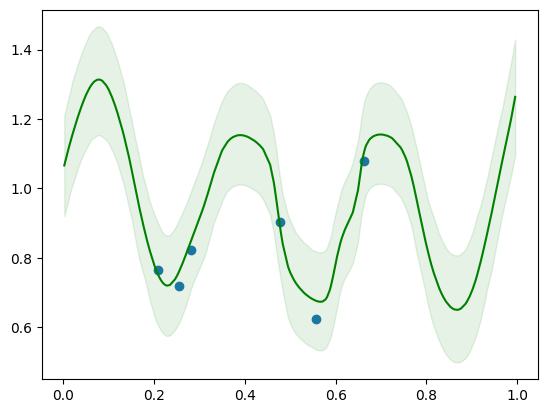

In [23]:
# our model wants the seq dimension first, remember that!

batch_index = 0 # change this to see other examples
num_training_points = 6

train_x = batch.x[:num_training_points, batch_index]
train_y = batch.y[:num_training_points, batch_index]
test_x = batch.x[:, batch_index]

with torch.no_grad():
    # we add our batch dimension, as our transformer always expects that
    logits = trained_model_sine(train_x[:,None], train_y[:,None], test_x[:,None])

# the model has the criterion still attached (it is the same though, as our criterion above)
# the criterion has a lot of handy function to use these logits
pred_means = trained_model_sine.criterion.mean(logits)
pred_confs = trained_model_sine.criterion.quantile(logits)


plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[...,0 , 0][order_test_x], pred_confs[...,0 ,1][order_test_x], alpha=.1, color='green')

We can see that the predictions appear, as we expect it, in a sine shape, too.

### ii) Anti-sine Regression. Let's play with `batch.target_y`

In all `get_batch` functions so far we specified two `y`s. We did this because there is a difference in how they are treated by the training loop. `batch.y` is used to feed it to the PFN as knowledge about the training set, while `batch.target_y` is used to train the transformer to predict it.

Typically we use a different `batch.target_y` s.t. we train not to fit the noise. In EI for example one often prefers EI over predictions that do not take inherent noise into account, as that changes the confidence intervals.

We will use the same prior as before, but make our model predict the middle of the sine wave instead of the wave itself.

In [24]:
def get_batch_for_anti_sine_ridge_regression(batch_size=10,seq_len=100,num_features=1, 
                                             hyperparameters=None, **kwargs):
    if hyperparameters is None:
        hyperparameters = {'a': 0.01, 'b': 1.0, 's': .3}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))

    xs = torch.rand(batch_size, seq_len, num_features)
    mean_ys = torch.einsum('nmf, nf -> nm',
                     torch.cat([xs,torch.ones(batch_size, seq_len,1)],2),
                     ws
                    )
    ys = torch.distributions.Normal(
        mean_ys,
        hyperparameters['a']
    ).sample()
    
        
    ys += torch.sin(xs[...,0]*20) * hyperparameters['s']
    
    
    # the new part is in target_y
    return Batch(x=xs.transpose(0,1), y=ys.transpose(0,1), target_y=mean_ys.transpose(0,1))




Let's visualize this for one example:

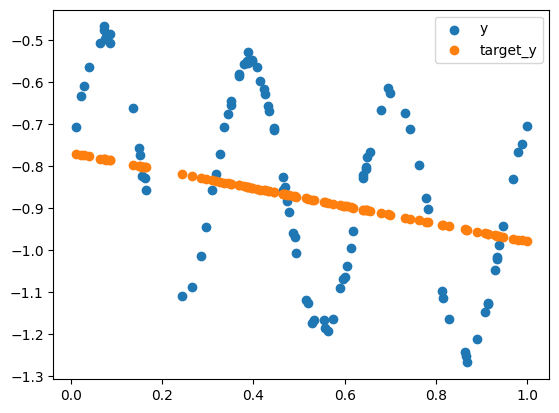

In [25]:
batch = get_batch_for_anti_sine_ridge_regression()

plt.scatter(batch.x[:,dataset_index,0].numpy(), batch.y[:,dataset_index].numpy(), label='y')
plt.scatter(batch.x[:,dataset_index,0].numpy(), batch.target_y[:,dataset_index].numpy(), label='target_y')

plt.legend()
plt.show()

In [26]:
# we use a large max_dataset_size s.t. we can show it with more training examples, which makes the effect more clear
train_results_anti_sine = train_a_pfn(get_batch_for_anti_sine_ridge_regression, max_dataset_size=100)
trained_model_anti_sine = train_results_anti_sine[2]

Using 2000000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 8, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7fa480d07ac0>, 'seq_len_maximum': 100, 'device': 'cpu:0', 'num_features': 1, 'fuse_x_y': False, 'hyperparameters': None}, 'num_features': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 1000)  and nout 1000
Using a Transformer with 0.82 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  5.91s | mean loss  1.60 | pos losses  1.18, 1.51, 1.69, 1.46, 1.55, 1.35,  nan,  nan, 1.46,  nan, 1.70, 1.42,  nan, 1.76,  nan, 1.35, 1.60,  nan, 1.64, 1.53, 1.83, 1.43, 2.01, 1.78,  nan, 1.95, 1.47,  nan, 1.44,  nan, 1.77,  nan, 1.65, 1.85, 1.48,  nan,  nan,  nan, 1.64, 1.43,  nan,  nan,

-----------------------------------------------------------------------------------------
| end of epoch   9 | time:  5.53s | mean loss -0.57 | pos losses  2.26, 0.77, 1.10, 0.28,  nan,  nan,-0.31,-0.37,-0.46,  nan,-0.31,-0.05,  nan,-0.53,  nan,-0.62,-0.93,-0.51,  nan,-0.79,-0.77,-0.63,-0.54,-0.88,  nan,  nan,-0.87,-0.77,  nan,-0.83,  nan,-0.68,-0.70,-0.78,-0.42,  nan,-1.03,  nan,  nan,-1.02,  nan,  nan,-0.66,-0.36,-0.61,-0.44,  nan,  nan,  nan,-0.81,-0.81,-0.93,  nan,  nan,-0.65,-0.84,  nan,-0.67,-0.79,  nan,  nan,-0.94,-0.75,-0.93,  nan,-0.83,  nan,-0.36,  nan,  nan,  nan,  nan,-0.89,  nan,  nan,-0.46,-0.53,  nan,  nan,-0.44,-0.67,-0.72,  nan,-0.77,  nan,-0.66,  nan,-0.81,-1.01,  nan,-1.01,-0.49,-0.83,  nan,-0.67,-0.48,-0.78,  nan,-0.78,-0.91, lr 0.0009045084971874737 data time  0.00 step time  0.06 forward time  0.02 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
---------------

-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  5.39s | mean loss -1.46 | pos losses  1.41, 0.85,  nan,-0.16,  nan,  nan,  nan,  nan,-1.04,  nan,-1.10,-1.18,-1.30,  nan,-1.22,  nan,  nan,-1.60,-1.50,-1.45,-1.24,-1.59,-1.53,  nan,-1.27,-1.51,  nan,-1.61,-1.60,-1.67,  nan,-1.35,  nan,-1.53,-1.72,  nan,  nan,  nan,-1.64,-1.59,  nan,-1.60,  nan,-1.51,  nan,-1.62,-1.62,  nan,-1.69,-1.63,  nan,-1.79,-1.59,-1.38,-1.51,-1.49,-1.68,-1.68,-1.61,-1.54,  nan,-1.57,  nan,-1.47,-1.78,-1.44,  nan,-1.51,  nan,-1.58,-1.78,-1.59,-1.72,  nan,-1.65,-1.54,-1.62,-1.62,-1.73,-1.61,-1.66,-1.76,-1.65,-1.72,  nan,-1.70,  nan,-1.65,-1.55,  nan,-1.68,-1.57,-1.64,-1.62,  nan,  nan,  nan,-1.62,-1.56,-1.54, lr 9.549150281252633e-05 data time  0.00 step time  0.05 forward time  0.02 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
---------------

If you see "nan" in the positional losses in the training log above that just means this particular `single_eval_pos` was not sampled.

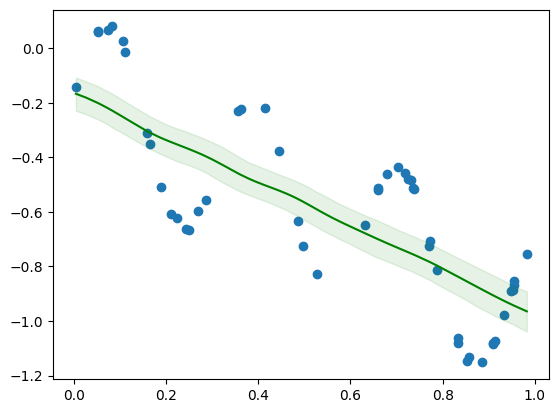

In [27]:
# our model wants the seq dimension first, remember that!

batch_index = 0 # change this to see other examples
num_training_points = 50

train_x = batch.x[:num_training_points, batch_index]
train_y = batch.y[:num_training_points, batch_index]
test_x = batch.x[:, batch_index]

with torch.no_grad():
    # we add our batch dimension, as our transformer always expects that
    logits = trained_model_anti_sine(train_x[:,None], train_y[:,None], test_x[:,None])

# the model has the criterion still attached (it is the same though, as our criterion above)
# the criterion has a lot of handy function to use these logits
pred_means = trained_model_anti_sine.criterion.mean(logits)
pred_confs = trained_model_anti_sine.criterion.quantile(logits)


plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[...,0 , 0][order_test_x], pred_confs[...,0 ,1][order_test_x], alpha=.1, color='green')

It looks like we can actually reconstruct the mean of the sine. This might be helpful for some obscure regression with a sine based noise..

### ONE ENCORE!! Let's do a GP as finale (and calculate EI on it)

For this we will use a prior that is already part of the pacakge in the `priors` folder. This folder is generally useful to store priors.

You can already have a sneak peak at what we will get out here, in our demo https://huggingface.co/spaces/samuelinferences/transformers-can-do-bayesian-inference

We will start by sampling some datasets in 1d from GP.

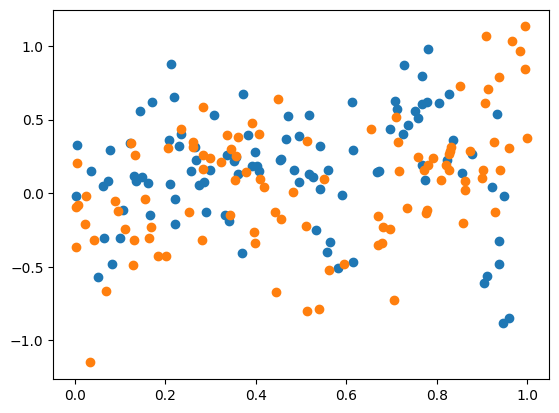

In [77]:
from pfns4bo.priors.fast_gp import get_batch as get_batch_for_gp

batch = get_batch_for_gp(batch_size=2, seq_len=100, num_features=1)
for dataset_index in range(batch.x.shape[1]):
    plt.scatter(batch.x[:,dataset_index,0].numpy(), batch.y[:,dataset_index].numpy())

### Now we can go ahead and train a PFN, let's go 🚂

In [71]:
from pfns4bo import priors

training_output_gp = train_a_pfn(get_batch_for_gp, hps={"noise": 1e-4, "outputscale": 1., "lengthscale": 0.1})
trained_model_gp = training_output_gp[2]

Using 2000000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 8, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7fa46cbc5cf0>, 'seq_len_maximum': 20, 'device': 'cpu:0', 'num_features': 1, 'fuse_x_y': False, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.1}}, 'num_features': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 1000)  and nout 1000
Using a Transformer with 0.82 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  3.08s | mean loss  1.45 | pos losses  1.43, 1.54, 1.43, 1.44, 1.47, 1.31, 1.51, 1.40, 1.47, 1.51, 1.43, 1.49, 1.44, 1.43, 1.42, 1.25, 1.47, 1.54, 1.35, 1.49, lr 0.0 data time  0.01 step time  0.02 forward time  0.01 nan share  0.00 ignor

-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  3.08s | mean loss  0.59 | pos losses  1.33, 1.33, 1.14, 1.10, 0.92, 0.94, 0.64, 0.61, 0.53, 0.51, 0.46, 0.22,  nan, 0.32, 0.23, 0.14, 0.09, 0.09, 0.06, 0.23, lr 0.00016543469682057105 data time  0.00 step time  0.02 forward time  0.01 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  2.74s | mean loss  0.51 | pos losses  1.38, 1.22, 1.25, 1.00, 0.81, 0.85, 0.64, 0.53, 0.52, 0.43, 0.39, 0.41, 0.35, 0.28, 0.19, 0.14, 0.08, 0.13, 0.08, 0.21, lr 9.549150281252633e-05 data time  0.00 step time  0.02 forward time  0.01 nan share  0.00 ignore share (for classification tasks) 0.0000
-------------------------------------------------------------------------------

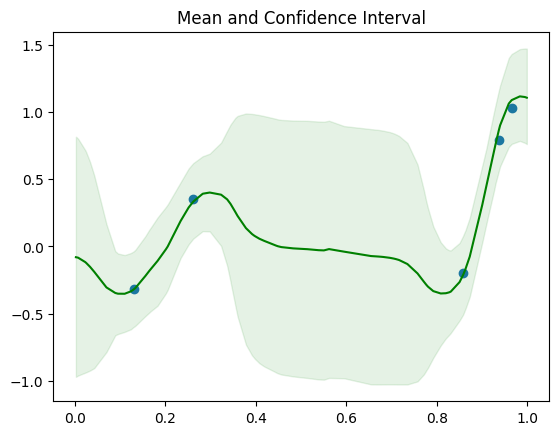

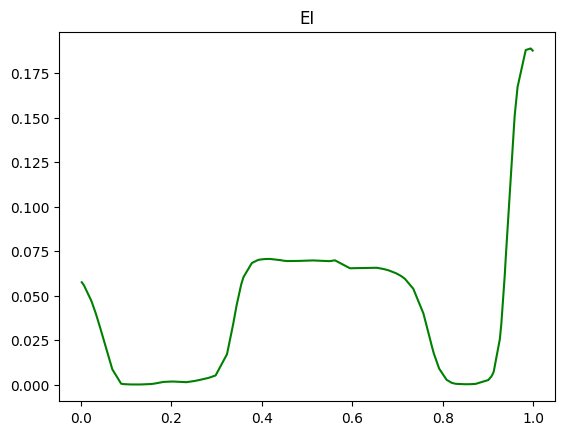

In [80]:
# our model wants the seq dimension first, remember that!

batch_index = 1 # change this to see other examples
num_training_points = 5

train_x = batch.x[:num_training_points, batch_index]
train_y = batch.y[:num_training_points, batch_index]
test_x = batch.x[:, batch_index]

with torch.no_grad():
    # we add our batch dimension, as our transformer always expects that
    logits = trained_model_gp(train_x[:,None], train_y[:,None], test_x[:,None])

# the model has the criterion still attached (it is the same though, as our criterion above)
# the criterion has a lot of handy function to use these logits
pred_means = trained_model_gp.criterion.mean(logits)
pred_confs = trained_model_gp.criterion.quantile(logits)

### WE CAN CALCULATE THE EI LIKE THIS:
pred_ei = trained_model_gp.criterion.ei(logits, best_f=max(train_y))


plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0], pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[...,0 , 0][order_test_x], pred_confs[...,0 ,1][order_test_x], alpha=.1, color='green')
plt.title('Mean and Confidence Interval')
plt.show()


plt.title('EI')
plt.plot(test_x[order_test_x, ..., 0], pred_ei[order_test_x], color='green', label='ei')
plt.show()